![Py4Eng](img/logo.png)

# Feed Forward Network
## Yoav Ram


In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax
import jax.numpy as np
import pandas as pd
from scipy.special import logit, expit
import scipy.ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix

blue, green, red = sns.color_palette('muted', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

We start by loading the MNIST digits data we used in the [softmax model session](softmax-model.ipynb).


In [2]:
from tensorflow import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train, Y_train, X_test, Y_test = X_train.astype('float32'), Y_train.astype('float32'), X_test.astype('float32'), Y_test.astype('float32')

In [3]:
nsamples, width, height = X_train.shape
nfeatures = width * height
# reshape and normalize to (0, 1)
X_train = X_train.reshape(nsamples, nfeatures) / 255 
X_test = X_test.reshape(-1, nfeatures) / 255

In [4]:
# if we are already using jax, we can use it for one-hot encoding, too
Y_train = jax.nn.one_hot(Y_train, 10)
Y_test = jax.nn.one_hot(Y_test, 10)
ncats = Y_test.shape[1]

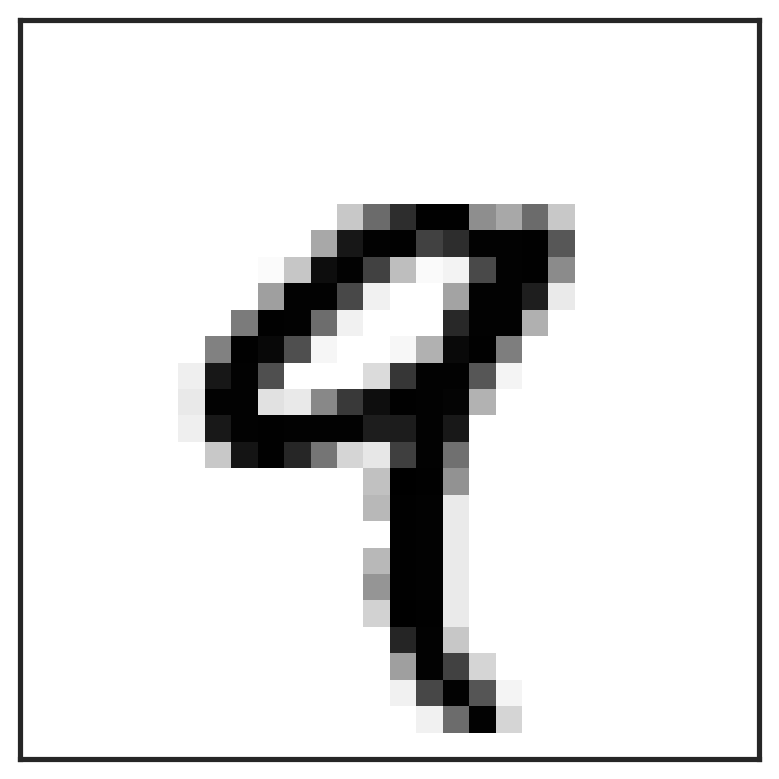

In [5]:
def display_image(im, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(im.reshape((28, 28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
    
display_image(X_train[4])

With softmax regression we got accuracy of ~87% (or even up to 92% if we run it longer, see the scikit-learn example).
But we talked about the problems with logistic models and that it might be that the relationship between pixels and categories is not linear or even monotone.
We also discussed a way to overcome this issue - polynomial features.

Here we will use another solution - the layering or composition of several linear models.

The idea is that for an input (features) $\mathbf{X_1}$, the model we will use is:

$$
\mathbf{X_2} = f_1(\mathbf{X_1} \cdot  \mathbf{W_1}) $$$$
\mathbf{X_3} = f_2(\mathbf{X_2} \cdot  \mathbf{W_2}) $$$$
\ldots $$$$
\mathbf{\widehat Y} = f_{n}(\mathbf{X_n})
$$

We will fit this model to the data by looking for $\mathbf{W_1}, \ldots, \mathbf{W_n}$ that give us a good prediction.

This kind of model is called a **feed forward network**.

# Two layers FFN

We start with two layers - the readout layer is the softmax regression layer, and before that we will have a hidden layer that transforms the input features $\mathbf{X_1}$ into complex features $\mathbf{X_2}$: each feature in $\mathbf{X_2}$ is a combination of all features in $\mathbf{X_1}$.

$$
\mathbf{X_2} = f_1(\mathbf{X_1} \cdot \mathbf{W_1}) $$$$
\mathbf{\widehat Y} = f_2(\mathbf{X_2} \cdot \mathbf{W_2})
$$

We already implemented these functions in the previous session:

In [6]:
def random_matrix(key, ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return jax.random.uniform(key, minval=-boundary, maxval=boundary, shape=(ninputs, noutputs))

softmax = jax.nn.softmax

def accuracy(Yhat, Y):
    return (Yhat.argmax(axis=1) == Y.argmax(axis=1)).mean()

# Exercise: ReLU
The readout layer uses the softmax function $f_2(z)=softmax(z)$.
What about $f_1(z)$?

To add some non-linearity to the model, we want to use a non-linear function, usually called [*activation function*](https://en.wikipedia.org/wiki/Activation_function).
For ease of use, we want a differentiable function that's easy and efficient to compute.

There are several options we can use, and a common choise is the rectifier, or [*ReLU*](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) function:

$$
ReLU(x) = \cases{x, & if x>0 \\ 0, & if x < 0}
$$

with a derivative

$$
ReLU'(x) = \cases{1, & if x>0 \\ 0, & if x < 0}
$$

Implement these functions.

Note that we can also just use the JAX implementation, `jax.nn.relu`.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

In [8]:
def ReLU(X):
    pass

def dReLU(X):
    pass

In [9]:
ReLU(np.linspace(-1, 1, 10))

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11111113, 0.33333337, 0.5555556 , 0.7777778 , 1.        ],      dtype=float32)

In [10]:
dReLU(np.linspace(-1, 1, 10))

Array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)

# Dropout

A simple way to avoid overfitting is to use [*dropout*](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf): randomly ignoring some elements of every layer during training (but not during prediction).

In [11]:
def dropout(X, key, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = jax.random.uniform(key, shape=(X.shape[1],)) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X = X.at[:, ~keeps].set(0) # ignore
        X = X.at[:, keeps].mul(1/keep_prob) # normalize
    return X

In [12]:
dropout(np.ones((5,5)), jax.random.PRNGKey(1), keep_prob=0.5)

Array([[0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 2., 2., 0., 0.]], dtype=float32)

# Feed Forward

Next, we want to write a function that for given input $\mathbf{X_1}$ calculates $\mathbf{\widehat Y}$.
But we also want to get all the intermediate layers, not just the final layer (the output, result of the readout layer).
The reason will become clear soon, when we write the back-propagation.

Prediction is then done by taking the last layer.

In [13]:
def feed_forward(Ws, X, key=None, keep_prob=1):
    X = np.atleast_2d(X)
    
    X1 = X
    W1, W2 = Ws
    
    # hidden layer
    Z1 = X1 @ W1 
    Z1 = dropout(Z1, key, keep_prob=keep_prob)
    X2 = ReLU(Z1) 
    
    # readout layer
    Z2 = X2 @ W2 
    Yhat = softmax(Z2) 
    return [X1, Z1, X2, Z2, Yhat]

def predict(Ws, X):    
    return feed_forward(Ws, X)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

5


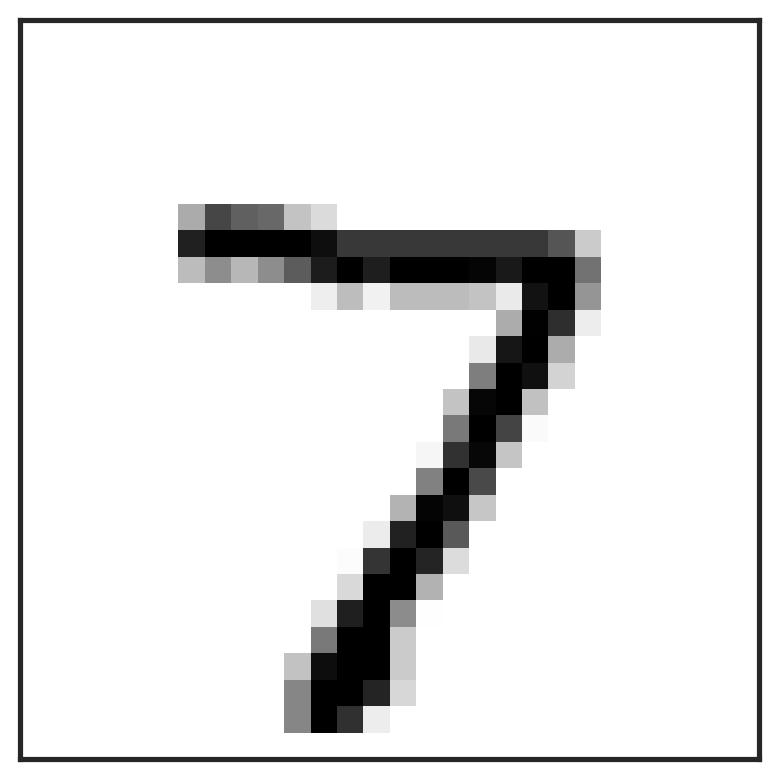

In [14]:
nhidden = 100
key = jax.random.PRNGKey(1)
W1 = random_matrix(jax.random.PRNGKey(21), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(12), nhidden, ncats)
Ws = [W1, W2]

display_prediction(0)

# Exercise: feed-forward

Rewrite `feed_forward` using a `for` loop so that it would work for any number of hidden layers.

In [15]:
# your code here

4


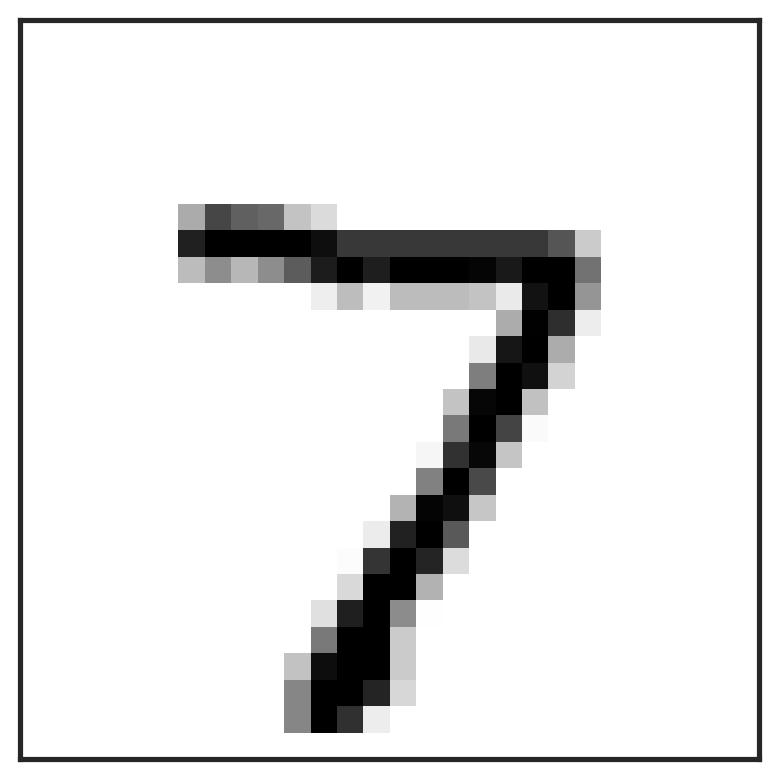

In [16]:
nhidden = 100
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

layers = feed_forward(Ws, X_train[:50])
assert len(layers) == 5
display_prediction(0)

# Back propagation

We now arrive at the most complicated and important part: the calculation of the gradeints of the loss function with respect to the $\mathbf{W_k}$ matrices - the model parameters, the weights of the network.

Since we use the softmax function, the loss function is still the cross-entropy function $\mathbf{J}(\mathbf{W_1}, \ldots, \mathbf{W_n} \mid \mathbf{X_1}, \mathbf{Y})$, the negative of the log-likelihood.

We know how to do gradient descent, but we need to calculate the gradient.
This seems at first very hard for a model as complex as:
$$
\mathbf{Z_1} = \mathbf{X_1} \cdot  \mathbf{W_1} $$$$
\mathbf{X_2} = f_1(\mathbf{Z_1}) $$$$
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} $$$$
\mathbf{X_3} = f_2(\mathbf{Z_2}) $$$$
\ldots $$$$
\mathbf{\widehat Y} = f_{n}(\mathbf{Z_n}) $$$$
\mathbf{J} = - \sum_{j=1}^{nsamples}{ \sum_{k=1}^{ncats}{y_{j,k} \log{\widehat y_{j,k}}} }
$$

But we actually know how to calculate the gradient at each layer $\frac{\partial \mathbf{X_k}}{\partial \mathbf{X_{k-1}}}$ so calculating the gradient with respect to any $\mathbf{W_k}$ is just a matter of applying the chain rule as many times as we need.

The idea is that we first calculate the loss function - **feed forward**.
Then we apply the chain rule in reverse iteration to calculate the gradient of the loss function $\mathbf{J}$ with respect to all $\mathbf{W_k}$.
Since the gradient at any layer is calculated as a function of the error measured in the previous layer, we essentially propagate the error backwards, thus the name for this algorithm - [**back propagation**](https://en.wikipedia.org/wiki/Backpropagation).

To calculate $\partial \mathbf{J}/\partial W_2$ we have the exact same calculation as in the [logistic](logistic-model.ipynb) or softmax model (makes sense as $\mathbf{W_2}$ is the softmax layer)

$$
\frac{\partial \mathbf{J}}{\partial W_2} = 
\frac{\partial \mathbf{J}}{\partial \widehat Y} \cdot \frac{\partial \widehat Y}{\partial Z_2} \cdot  \frac{\partial Z_2}{\partial W_2}
$$

To calculate $\partial \mathbf{J}/\partial \mathbf{W_1}$ (which is a matrix with the same number of entries as $\mathbf{W_1}$) we can use a similar but longer calculation as the readout layer:

$$
\frac{\partial \mathbf{J}}{\partial \mathbf{W_1}} = 
\frac{\partial \mathbf{J}}{\partial \mathbf{\widehat Y}} \cdot \frac{\partial \mathbf{\widehat Y}}{\partial \mathbf{Z_2}} \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} \cdot \frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}
$$

Note that the first terms of this product were already calculated when calculating $\frac{\partial C}{\partial \mathbf{W_2}}$; the term 

$$
\delta_2 = \frac{\partial \mathbf{J}}{\partial \mathbf{\widehat Y}} \cdot \frac{\partial \mathbf{\widehat Y}}{\partial \mathbf{Z_2}}
$$

is considered the error of the previous layer, and it is back-propagated to the next layer:

$$
\frac{\partial \mathbf{J}}{\partial \mathbf{W_1}} = 
\delta_2 \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} \cdot \frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}
$$

These are three easy opeations:
$$
\frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} = \frac{\partial ReLU{(\mathbf{Z_1})}}{\partial \mathbf{Z_1}} = ReLU'(\mathbf{Z_1}) $$$$
\frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}=\frac{\partial (\mathbf{X_1} \mathbf{W_1})}{\partial \mathbf{W_1}} = \mathbf{X_1} $$$$
\frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} = \frac{\partial (\mathbf{X_2} \mathbf{W_2})}{\partial \mathbf{X_2}} = \mathbf{W_2}
$$

In the next layer $\delta_1$ is updated to 
$$
\delta_1 = \delta_2 \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} = \delta_2 \cdot W_2 \cdot Relu'(Z_1),
$$
thus *propagating back* the error $\delta$.

Consider that in forwarding we use the matrix multiplication to activate each node as a weighted average of the previous nodes (the weights given by $\mathbf{W_k}$). 
Back propagation can be considered the reverse operation.

The actual operators used below are chosen to avoid loops (except the loop through the layers which is unavoiable) and to keep the correct dimensions - see the discussion in the [softmax model session](softmax-model.ipynb#Gradient-descent).

In [17]:
def cross_entropy(Ws, X, Y):
    Yhat = predict(Ws, X)
    return -(Y * np.log(Yhat)).sum()

In [18]:
def back_propagation(Ws, X, Y, key=None, keep_prob=1):
    W1, W2 = Ws
    X1, Z1, X2, Z2, Yhat = feed_forward(Ws, X, key, keep_prob=keep_prob)

    # readout layer
    δ2 = Yhat - Y # prediction error, dJ/dYhat * dYhat/dZ2 (-1, ncats)
    dJdW2 = X2.T @ δ2 # dJ/dW2 = δ2 * dZ2/dX2 = δ2 * X2

    # hidden layer
    δ1 = (δ2 @ W2.T) * dReLU(Z1) # δ1 = dJ/dX_2 = δ2 * dZ2/dX2 * dX2/dZ1 = δ2 * W2 * ReLU(Z1)
    dJdW1 = X1.T @ δ1 # dJ/dW1 = δ1 * dZ1/dW1 = δ1 * X1

    dJdWs = [dJdW1, dJdW2]
    # sanity checks
    assert len(dJdWs) == len(Ws), (len(dJdWs), len(Ws))
    for dJdWi, Wi in zip(dJdWs, Ws):
        assert dJdWi.shape == Wi.shape, (dJdWi.shape, Wi.shape)
    return dJdWs

In [19]:
nhidden = 100
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

X_, Y_ = X_train[:50, :], Y_train[:50, :]
dW1, dW2 = back_propagation(Ws, X_, Y_)

# Gradient checking

Writing and implementing the gradient computation can be really hard.
But there is a good way to sanity-check that we made the correct computation.

Remember that the definition of a derivative is
$$
\frac{d f}{d x}\big(x\big) = \lim_{\Delta \to 0}{\frac{f(x+\Delta) - f(x-\Delta)}{2\Delta}}
$$
Therefore, we can compute the cross entropy at the params, then slightly change each parameter and compute the cross entropy again, and use these two computations as $f(x+\Delta)$ and $f(x-\Delta)$ where $x$ is the parameter we changed and $\Delta$ is the slight change. 
Then we can compare $\frac{f(x+\Delta)-f(x-\Delta)}{2\Delta}$ to the gradient computed by back propagation and check that the difference is very small.

However, because we have the power of JAX, we can do something better.

# Automatic differentiation with JAX

Instead of manually deriving the gradient and implementing it as a Python program, we use *JAX's automatic differentiation**.

[`jax.grad`](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#taking-derivatives-with-grad) takes a function `f(a, b, c)` and returns a function `dfda(a, b, c)` that returns the gradient of `f` with respect to `a` at the values of `a`, `b`, and `c`. It does so by automating the procedure we did manually using the chain rule.

In our case, `f` is `cross_entropy`, `a` is `Ws`, and `b` and `c` are `X` and `Y`.

In [20]:
backprop_jax = jax.grad(cross_entropy)
backprop_jax(Ws, X_train[:50, :], Y_train[:50, :]);

In [21]:
def gradient_check(Ws, X, Y):
    grads1 = back_propagation(Ws, X, Y)    
    grads2 = backprop_jax(Ws, X, Y) 
    for g1, g2 in zip(grads1, grads2):
        assert np.allclose(g1, g2, atol=1e-6)

In [22]:
nhidden = 10
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

X_, Y_ = X_train[:50, :], Y_train[:50, :]
gradient_check(Ws, X_, Y_)

# Exercise: back propagation

To make sure we understand back propagation, let's rewrite the `back_propagation` function with a `for` loop for networks with more than a single hidden layer.

In [23]:
# your code here

In [24]:
# gradient check for 2 layers
nhidden = 10
W1 = random_matrix(jax.random.PRNGKey(1), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(2), nhidden, ncats)
Ws = [W1, W2]
X_, Y_ = X_train[:100,:], Y_train[:100,:]
gradient_check(Ws, X_, Y_)

In [25]:
# gradient check for 3 layers
nhidden = 10
W1 = random_matrix(jax.random.PRNGKey(1), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(2), nhidden, nhidden)
W3 = random_matrix(jax.random.PRNGKey(3), nhidden, ncats)
Ws = [W1, W2, W3]
X_, Y_ = X_train[:100,:], Y_train[:100,:]
gradient_check(Ws, X_, Y_)

# Momentum gradient descent

There are many different ways to do stochastic gradient descent.
Some of the algorithms adapt the learning rate $\eta$ during training. 
The basic intuition is that when we are far from the minimum we want to advance in big steps and when we are near to the minimum we want to advance more carefully.

The first optimization method we will use was described in [Rumelhart, Hinton & Williams, 1986](http://www.nature.com/doifinder/10.1038/323533a0).
It is a momentum method, meaning that at each iteration (batch) the current update is calculated as a decaying average of the previous update and the current gradients:

$$
\Delta W \to \alpha \Delta W - \eta \frac{\partial J}{\partial W} $$$$
W \to W + \Delta W
$$

This works fine, sometimes, but not as good as other algorithms. It simple and easy to implement, though, and gives a good sense of what other momentum-based algorithms do.
See a [comparison of algorithms on MNIST](https://github.com/mazefeng/sgd-opt).

In [27]:
def momentum(dJdWs, ΔWs, α=0.9, η=0.05): 
    ΔWs = [
        α * ΔW - η * dJdW
        for ΔW, dJdW in zip(ΔWs, dJdWs)
    ]        
    return ΔWs

In [28]:
ΔWs = [0.0] * len(Ws)
dJdWs = back_propagation(Ws, X_train[:50], Y_train[:50])
ΔWs = momentum(dJdWs, ΔWs)

# JITing the training step

We write a function that does a single gradient descent step, and pass it to `jax.jit`, which [just-in-time compiles the function](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) so it can be executed efficiently in XLA.

We return: 
- `Ws` (the parameters) because that's what we are interested in
- `ΔWs` (the updates) so we can use it in the next iteration
- `dJdWs` (the gradients) for debugging (see below).

In [29]:
@jax.jit # reduces running time from 2 ms to 400 µs
def gradient_descent(Ws, ΔWs, X, Y, η):
    X = np.atleast_2d(X) # consistent with scikit-learn and keras that want X to be 2D    
    dJdWs = back_propagation(Ws, X, Y)
    ΔWs = momentum(dJdWs, ΔWs, α, η) 
    Ws = [W + ΔW for W, ΔW in zip(Ws, ΔWs)]
    return Ws, dJdWs, ΔWs 

gradient_descent(Ws, ΔWs, X_train[:50], Y_train[:50], η=0.05);

In [30]:
%timeit gradient_descent(Ws, ΔWs, X_train[:50], Y_train[:50], η=η);

362 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Training the FFN

In [31]:
def train(Ws, num_epochs, η, debug=False):
    epochs = 0
    batches = 0
    ΔWs = [0] * len(Ws)

    while epochs < num_epochs:
        batches += 1
        epochs = batches * batch_size // nsamples
        
        # get next batch
        start = (batches * batch_size) % nsamples
        stop = start + batch_size
        X_, Y_ = X_train[start:stop, :], Y_train[start:stop, :]
        
        # gradient descent
        Ws, dJdWs, ΔWs = gradient_descent(Ws, ΔWs, X_, Y_, η=η)
        
        # print once every epoch
        if batches * batch_size % nsamples == 0:
            acc = accuracy(predict(Ws, X_test), Y_test)
            print("Epoch {}, test accuracy: {}".format(epochs, acc))   
            if debug:
                print("Gradients:")
                for dJdW in dJdWs:
                    print('\t', dJdW.min(), dJdW.mean(), dJdW.max())
    return Ws

In [32]:
batch_size = 50 

nhidden = 100
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

print("Accuracy:", accuracy(predict(Ws, X_test), Y_test))

Accuracy: 0.119399995


In [33]:
Ws = train(Ws, 3, η=0.05)

Epoch 1, test accuracy: 0.09799999743700027
Epoch 2, test accuracy: 0.09799999743700027
Epoch 3, test accuracy: 0.09799999743700027


Training is stuck. Let's look at the gradients.

In [34]:
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

Ws = train(Ws, 3, η=0.05, debug=True)

Epoch 1, test accuracy: 0.09799999743700027
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0
Epoch 2, test accuracy: 0.09799999743700027
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0
Epoch 3, test accuracy: 0.09799999743700027
Gradients:
	 0.0 0.0 0.0
	 0.0 0.0 0.0


That's not good, the gradients are all zero. Let's try a lower learning rate $\eta$.

In [35]:
W1 = random_matrix(jax.random.PRNGKey(12), nfeatures, nhidden)
W2 = random_matrix(jax.random.PRNGKey(21), nhidden, ncats)
Ws = [W1, W2]

Ws = train(Ws, 3, η=0.0001)

Epoch 1, test accuracy: 0.9197999835014343
Epoch 2, test accuracy: 0.9354999661445618
Epoch 3, test accuracy: 0.9443999528884888


Now it's working, let run it for more epochs.

In [36]:
Ws = train(Ws, 30, η=0.0001)

Epoch 1, test accuracy: 0.9506999850273132
Epoch 2, test accuracy: 0.9564999938011169
Epoch 3, test accuracy: 0.9599999785423279
Epoch 4, test accuracy: 0.963699996471405
Epoch 5, test accuracy: 0.965399980545044
Epoch 6, test accuracy: 0.967199981212616
Epoch 7, test accuracy: 0.9682999849319458
Epoch 8, test accuracy: 0.9688999652862549
Epoch 9, test accuracy: 0.97079998254776
Epoch 10, test accuracy: 0.9720999598503113
Epoch 11, test accuracy: 0.9724999666213989
Epoch 12, test accuracy: 0.9731999635696411
Epoch 13, test accuracy: 0.974299967288971
Epoch 14, test accuracy: 0.9745999574661255
Epoch 15, test accuracy: 0.9750999808311462
Epoch 16, test accuracy: 0.9759999513626099
Epoch 17, test accuracy: 0.9764999747276306
Epoch 18, test accuracy: 0.9764999747276306
Epoch 19, test accuracy: 0.976699948310852
Epoch 20, test accuracy: 0.9770999550819397
Epoch 21, test accuracy: 0.9771999716758728
Epoch 22, test accuracy: 0.9768999814987183
Epoch 23, test accuracy: 0.9767999649047852
Epoc

Great! We trained our FFN to a very high accuracy! 

0


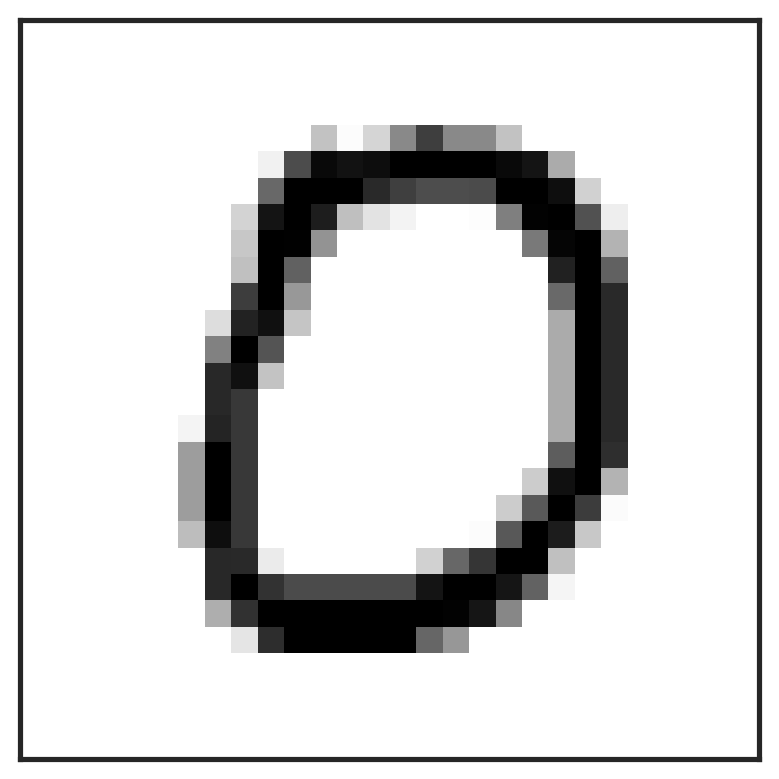

In [37]:
display_prediction(10)

# Confusion

We can also explore the confusion matrix to see which digits are commonly confused with which digits.

In [38]:
y_true = Y_test.argmax(axis=1)
y_pred = predict(Ws, X_test).argmax(axis=1)

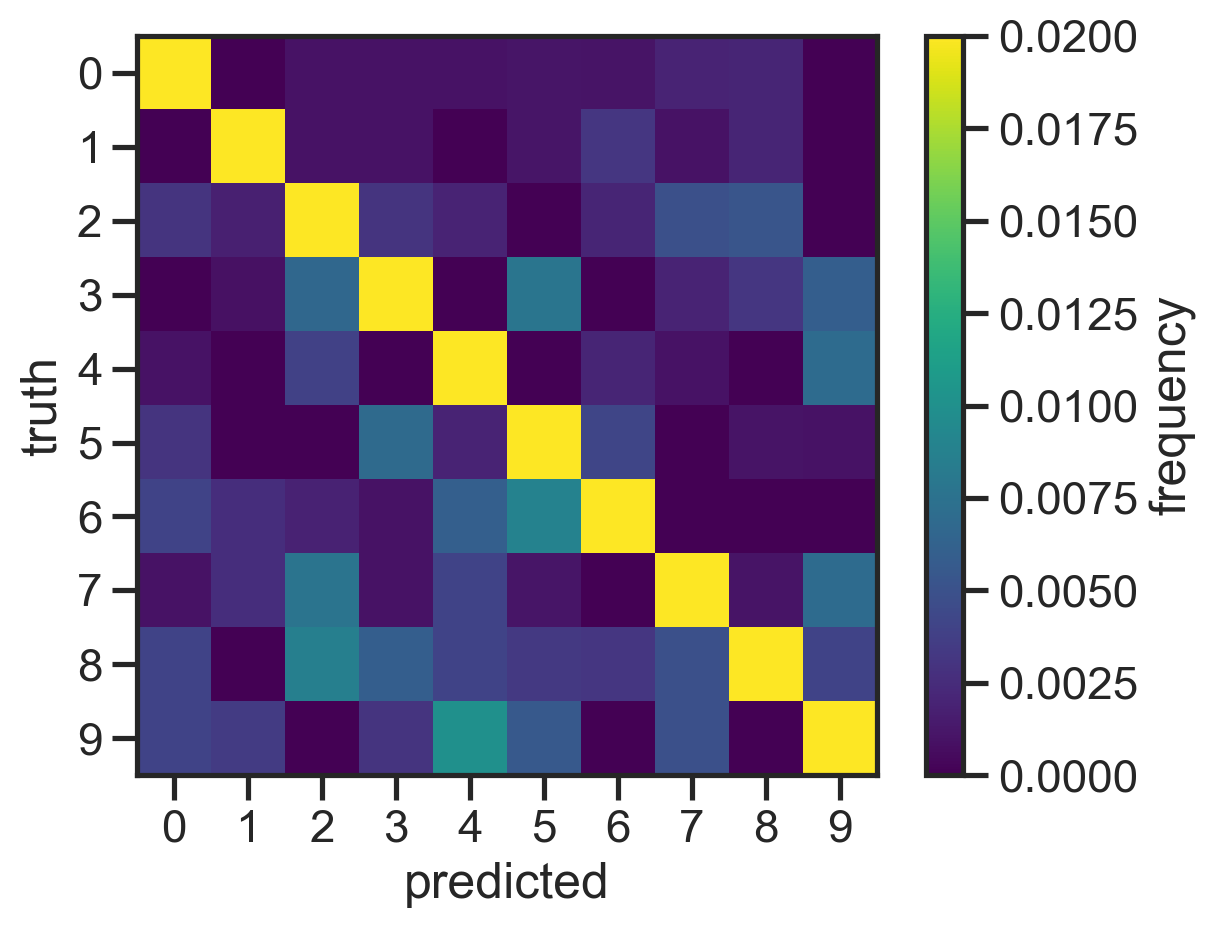

In [39]:
conf = confusion_matrix(y_true, y_pred, normalize='pred')
plt.imshow(conf, origin='upper', cmap='viridis', vmin=0, vmax=0.02)
plt.xlabel('predicted')
plt.ylabel('truth');
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar(label='frequency');

Here we explore specific cases of confusion.

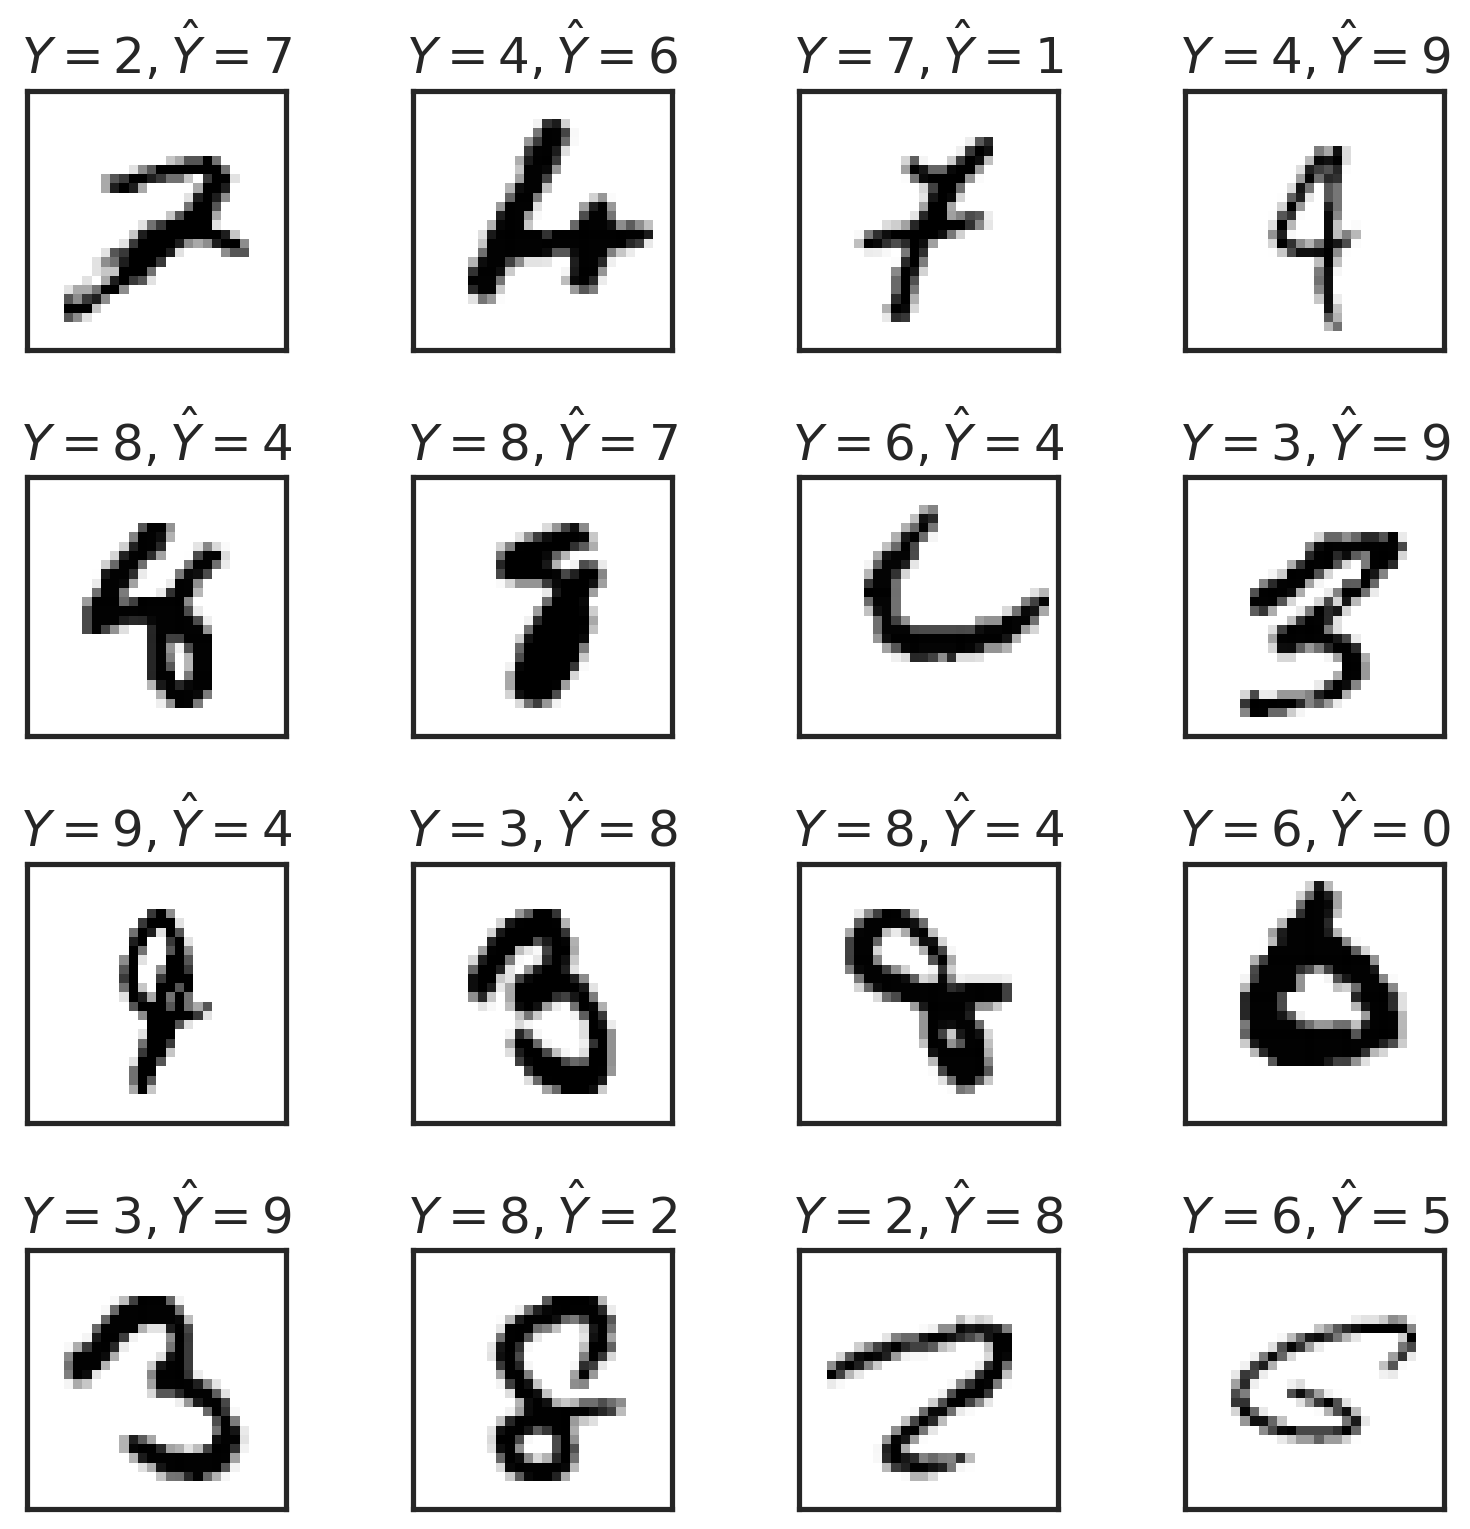

In [40]:
num_cols = 4

idx = y_pred != y_true
choices = jax.random.choice(jax.random.PRNGKey(1), np.arange(idx.size), shape=(num_cols*num_cols,), replace=False, p=idx/idx.sum())

fig, axes = plt.subplots(num_cols, num_cols, figsize=(2*num_cols, 2*num_cols))
for i in range(num_cols):
    for j in range(num_cols):
        choice = choices[i*num_cols+j]
        display_image(X_test[choice], ax=axes[i,j])
        axes[i,j].set_title('$Y={}, \hat Y={}$'.format(y_true[choice], y_pred[choice]))
fig.tight_layout()

# Problems

One major problem is that FFN learns the relationship $W_{k,j}$ between pixel (feature) $x_j$ and digit (category) $k$, but if we move the pixels around without changing the category, the relationship is lost.
The model sees the features as a sequence of length 728, and it doesn't "know" that it's actually a 2D matrix of 28x28.

Because of that, it can't tell that a shifted 5 is still a 5.

5


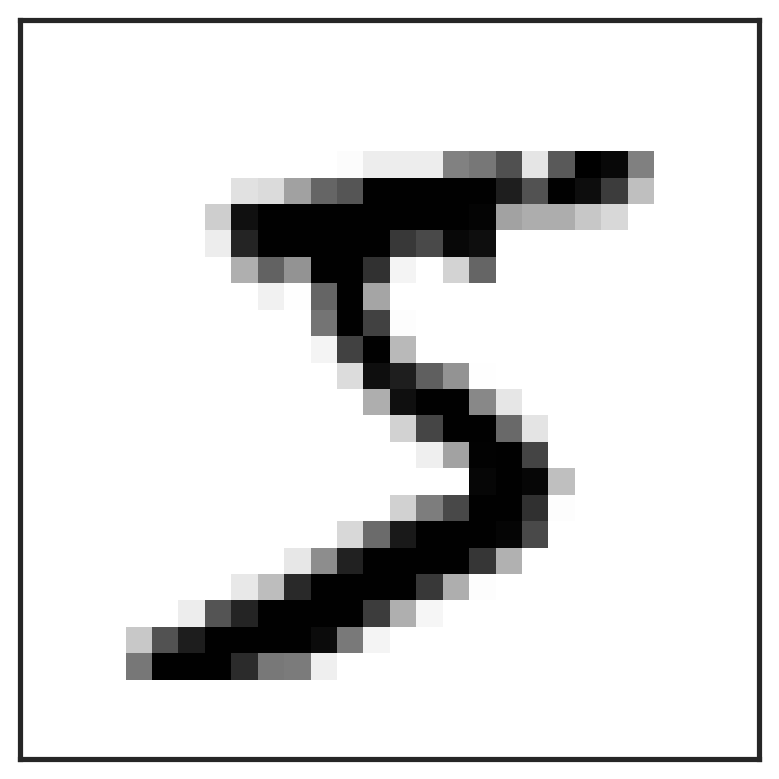

In [41]:
im = X_train[0]
print(predict(Ws, im).argmax())
display_image(im)

`scipy.ndimage` has a bunch of useful image analysis functions, but also see *scikit-image*.

2


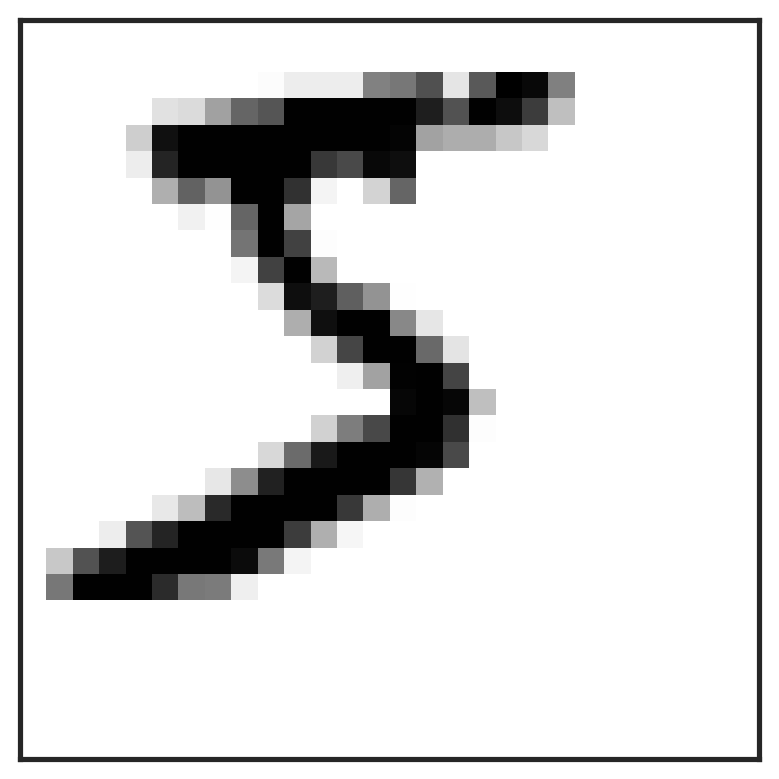

In [42]:
shifted = scipy.ndimage.shift(im.reshape((28, 28)), -3)
print(predict(Ws, shifted.ravel()).argmax())
display_image(shifted)

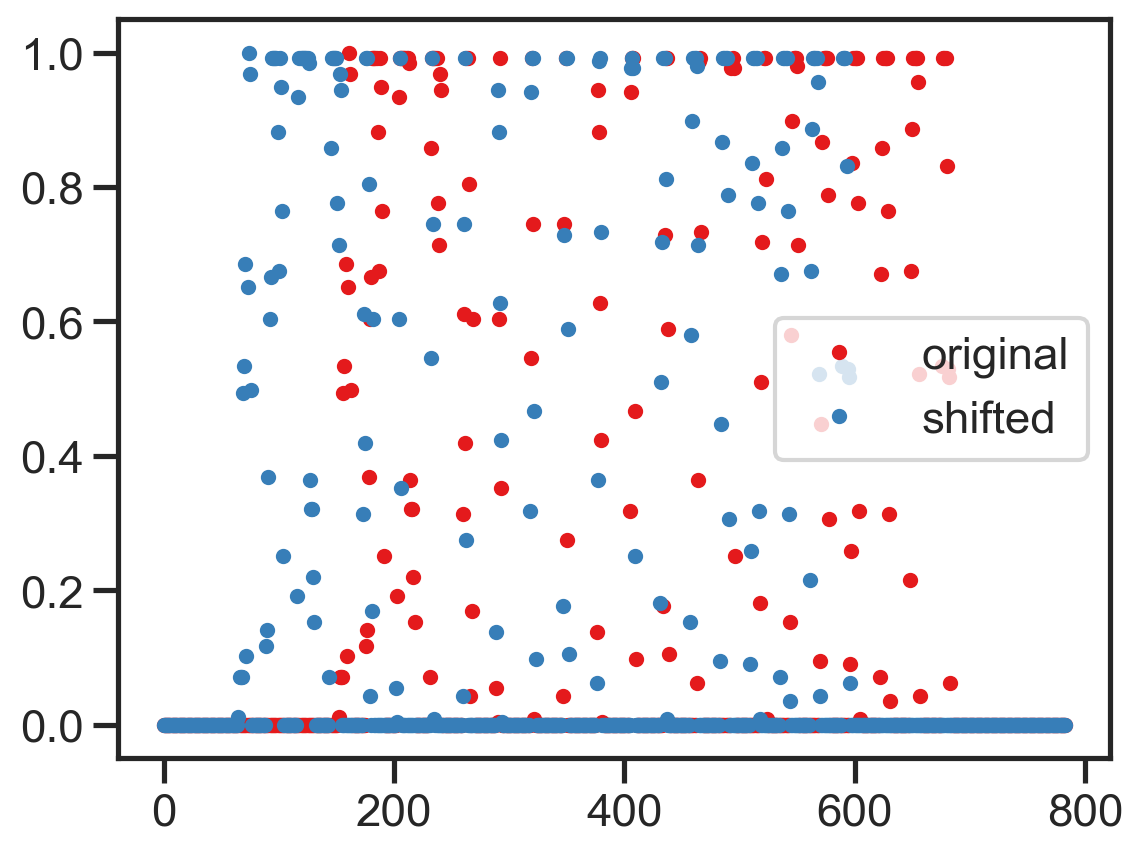

In [43]:
plt.plot(im.ravel(), '.', label='original')
plt.plot(shifted.ravel(), '.', label='shifted')
plt.legend();

A solution to this, which also offers other benefics such as faster training and more efficient memory use, is the use of *convolutional neural networks*, which use convolutions instead of fully connected (matrix multiplcation) layers.
We will deal with such networks in [another session](CNN.ipynb).

# References

- [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 6, 7.12, and 8 - offers a comprehensive introduction to the subject.
- [Deep Learning: Technical introduction by Thomas Epelbaum](https://github.com/tomepel/Technical_Book_DL), ch. 4 - offers a very technical perspective with full derivation of all the formulas.

Both books are available online for free.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)